# **CMIP6 Interpolation Methods**

## **Bilinear Interpolation**

Let $f(s,t)$ be a real-valued function with a two-dimensional input $(s,t)$. 

Assume we observe the function values $f(s_1,t_1)$, $f(s_1,t_2)$, $f(s_2,t_1)$, and $f(s_2,t_2)$. 

Now consider any $(s,t)$ within the rectangle defined by $(s_1,t_1)$, $(s_1,t_2)$, $(s_2,t_1)$, and $(s_2,t_2)$ where $s_1 < s < s_2$ and $t_1 < t < t_2$. 

Bilinear interpolation is conducted in two parts:

#### Part 1: Interpolate in s-direction

\begin{equation}
    f(s,t_1) = \frac{s_2 - s}{s_2 - s_1}\;f(s_1,t_1) + \frac{s - s_1}{s_2 - s_1}\;f(s_2,t_1)
\end{equation}


\begin{equation}
    f(s,t_2) = \frac{s_2 - s}{s_2 - s_1}\;f(s_1,t_2) + \frac{s - s_1}{s_2 - s_1}\;f(s_2,t_2)
\end{equation}

#### Part 2: Interpolate in t-direction

\begin{equation}
    f(s,t) = \frac{t_2 - t}{t_2 - t_1}\;f(s,t_1) + \frac{t - t_1}{t_2 - t_1}\;f(s,t_2)
\end{equation}



## **Nearest Neighbor**

This method chooses $f(\boldsymbol{x})$ using the nearest neighbor of $\boldsymbol{x}$ from the observed dataset.


## **Inverse Distance Weighting**

This method computes the distance between the target location $\boldsymbol{x}$ and the $n$ sample locations $\boldsymbol{x}_i,\ldots,\boldsymbol{x}_n$. 

Then, the prediction at $\boldsymbol{x}$ is computed by a weighted average 

\begin{equation}
    f(\boldsymbol{x}) = \frac{\sum_{i = 1}^n w_i(\boldsymbol{x}) f(\boldsymbol{x}_i)}{\sum_{i = 1}^n w_i(\boldsymbol{x})}
\end{equation}

where $w_i(\boldsymbol{x}) = 1/d(\boldsymbol{x},\boldsymbol{x}_i)$ for some distance metric $d()$.

The inverse weighting scheme can be improved by limiting the weighted average to a local neighborhood around $\boldsymbol{x}$ with radius $R$.

Lastly, if $\boldsymbol{x} = \boldsymbol{x}_i$ for some $i$, then $f(\boldsymbol{x}) = f(\boldsymbol{x}_i)$. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import cftime
import xarray as xr 
import netCDF4 as nc

from tqdm import tqdm
from scipy.interpolate import interp2d
from sklearn.neighbors import KNeighborsRegressor

#scidata_path = os.getcwd().split("SciData")[0] + "SciData"
#sys.path.append(scidata_path)
#from Climate.src.interpolators import bilinear, nearest_neighbor, invdw


In [9]:
#----------------------------------------------------------
# Functions
#----------------------------------------------------------
def get_timeperiod(f):
    rng = f.split('_')[-1][:-3]
    return [int(s[:-2]) for s in rng.split('-')]


In [10]:
#----------------------------------------------------------
# TAS from list
#----------------------------------------------------------
cmip6path = "/home/johnyannotty/NOAA_DATA/CMIP6/historical/"
#filename = "tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc"
#filename =  "tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc"
#dset = xr.open_dataset(cmip6path+filename, decode_times=True, use_cftime=True)

file_list = sorted(os.listdir(cmip6path))
file_list = [f for f in file_list if "tas_" in f]
tas_data = []
lat_data = []
lon_data = []
fillval_data = []
i = 0
for f in file_list:
    ncdata = nc.Dataset(cmip6path + f, "r")

    # Get index and appropriate time period
    tp = get_timeperiod(f)
    n_begin = (1950 - tp[0]) * 12
    n_end = (2015 - tp[0]) * 12

    # Pull the temperature data using the indexes & convert to celsius 
    xi = ncdata.variables['tas'][n_begin:n_end]
    xi = np.array(xi)
    xi = np.array(xi) - 273.15
    
    # Rotate and flip to get the eastern and western hemisphere oriented correctly
    #xi = np.rot90(xi, k = 2, axes = (1, 2))
    #xi = np.flip(xi, axis = 2)

    # Get the fill values
    fv = ncdata.variables['tas']._FillValue

    # Get longitude and latitude
    lat = np.array(ncdata.variables["lat"])
    lon = np.array(ncdata.variables["lon"])

    # Append to lists
    tas_data.append(xi)
    lat_data.append(lat)
    lon_data.append(lon)
    fillval_data.append(fv)
    i+=1



/tmp/ipykernel_82265/1760363503.py:25: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  xi = ncdata.variables['tas'][n_begin:n_end]


In [11]:
#----------------------------------------------------------
# ERA5 Pull
#----------------------------------------------------------
era5path = "/home/johnyannotty/NOAA_DATA/ERA5/"
ncdata = nc.Dataset(era5path + 'era5_avg_mon_tas/data_1990-2023.nc', "r")

era5_lon = np.array(ncdata.variables['longitude'])
era5_lat = np.array(ncdata.variables['latitude'])

del ncdata

In [12]:
# Read in ERA5 in a different format
era5 = xr.open_dataset(era5path + 'era5_avg_mon_tas/data_1990-2023.nc', decode_times=True, use_cftime=True)

# Get era5 mesh grid
era5_llmesh = np.meshgrid(era5_lon,era5_lat)
era5_lldf = pd.DataFrame()
era5_lldf["lon"] = era5_llmesh[0].ravel()
era5_lldf["lat"] = era5_llmesh[1].ravel()
del era5_llmesh


In [13]:
cmip6intpath = '/home/johnyannotty/NOAA_DATA/CMIP6_Interpolations/'
cmpi6_interp_files = []
for c,f in tqdm(enumerate(file_list),desc = "Simulator" ,leave = False):
    f = f.split("185")[0] + "2014.nc"
    cmpi6_interp_files.append(cmip6intpath + "bilinear_" + f)


In [14]:
#----------------------------------------------------------
# CMIP6 interpolations -- Access-CM2
#----------------------------------------------------------
cmip6intpath = '/home/johnyannotty/NOAA_DATA/CMIP6_Interpolations/'
for c,f in tqdm(enumerate(file_list),desc = "Simulator" ,leave = False):
    f = f.split("185")[0] + "2014.nc"
    #cmpi6_interp_files.append(cmip6intpath + "bilinear_" + f)
    try:
        ncfile = nc.Dataset(cmip6intpath + "bilinear_" + f,mode='w',format='NETCDF4_CLASSIC')
        lat_dim = ncfile.createDimension('lat', era5_lat.shape[0])     # latitude axis
        lon_dim = ncfile.createDimension('lon', era5_lon.shape[0])    # longitude axis
        time_dim = ncfile.createDimension('time', 12)#tas_data[0].shape[0]) # unlimited axis (can be appended to).

        ncfile.title=f
        ncfile.subtitle='TAS Interpolations'

        lat = ncfile.createVariable('lat', np.float32, ('lat',))
        lat.long_name = 'latitude'
        lat = era5_lat

        lon = ncfile.createVariable('lon', np.float32, ('lon',))
        lon.long_name = 'longitude'
        lon = era5_lon

        time = ncfile.createVariable('time', np.float64, ('time',))
        time.units = 'months of 2014'
        time.long_name = 'time'
        time = np.linspace(1,12,12)

        temp = ncfile.createVariable('tas',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
        temp.units = 'C'
        temp.standard_name = 't2m'


        # Batch Interpolations....(batch over time, long and lat)
        num_tpds = 12 # last 10 years of data
        
        for i in tqdm(range(num_tpds),desc = "Time Period",leave=False):
            tm = tas_data[c].shape[0] - num_tpds + i
            bilinear_interp = interp2d(np.array(lon_data[c]),np.array(lat_data[c]), tas_data[c][tm], kind = "linear")
            temp[i,:,:] = np.flip(bilinear_interp(np.array(era5_lon), np.array(era5_lat)),axis = 0)
        ncfile.close()
    except: 
        print("Error for file: " + f)
        ncfile.close()

### Comparing Simulators Post Interpolation

This section analyzes the accuracy of each simulator and resulting interpolation. This set of examples uses the bilinear interpolation strategy unless otherwise specified.

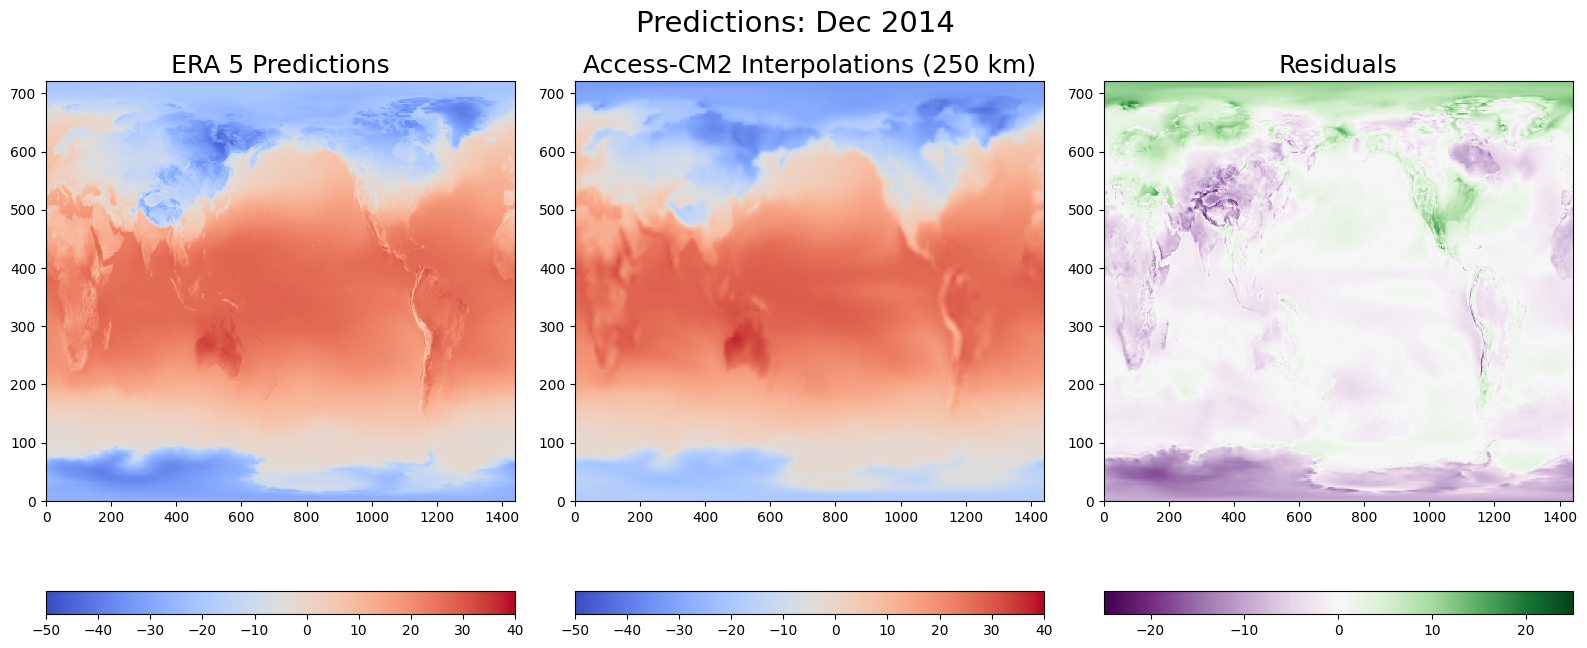

In [15]:
# Plot data
ncdata1 = nc.Dataset(cmpi6_interp_files[0], "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid1 = era5["t2m"][xx,0,:,:] - 273.15 - ncdata1["tas"][11]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(era5["t2m"][xx,0,:,:].transpose() - 273.15),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata1['tas'][11].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid1.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("ERA 5 Predictions", size = 18)
ax[1].set_title("Access-CM2 Interpolations (250 km)", size = 18)
ax[2].set_title("Residuals", size = 18)
fig.suptitle("Predictions: Dec 2014", size = 21)
fig.tight_layout()
plt.show()

ncdata1.close()


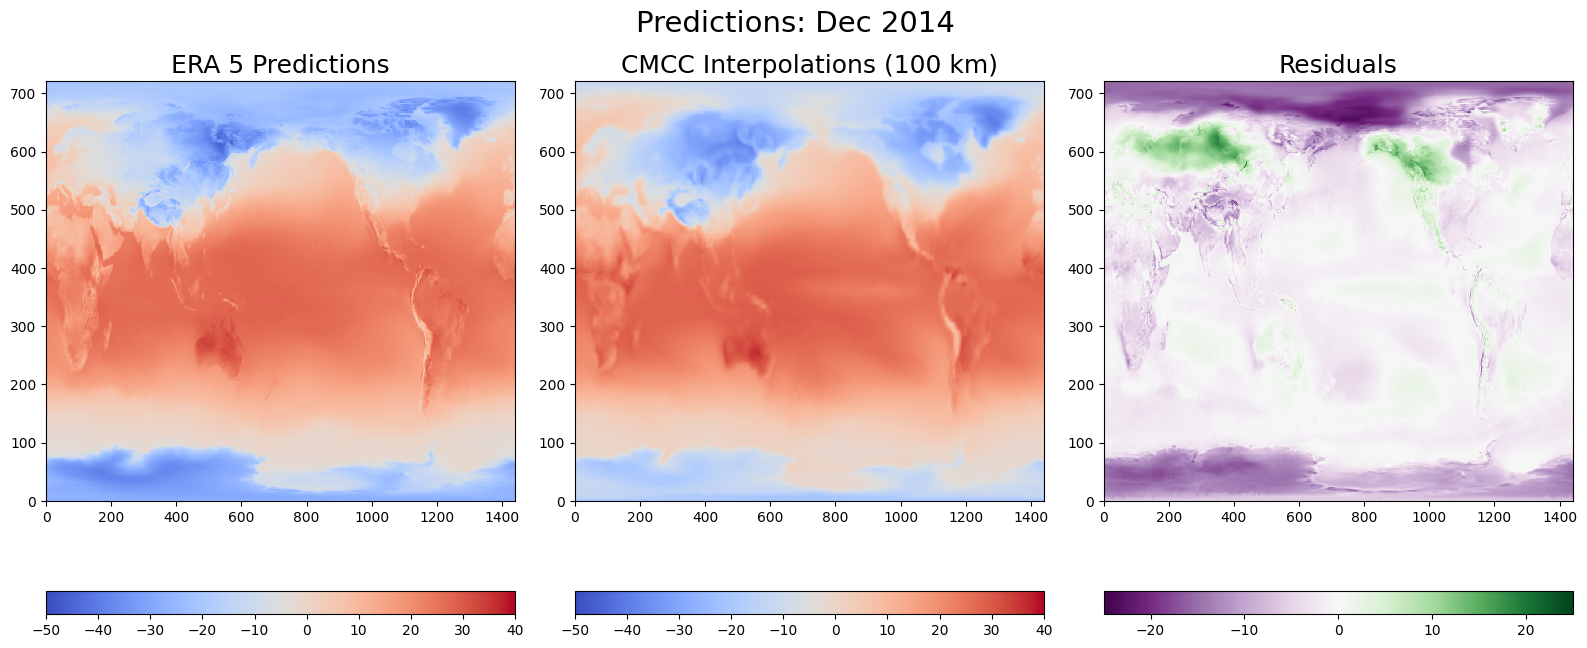

In [16]:
# Plot data
ncdata4 = nc.Dataset(cmpi6_interp_files[3], "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid4 = era5["t2m"][xx,0,:,:] - 273.15 - ncdata4["tas"][11]

fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(era5["t2m"][xx,0,:,:].transpose() - 273.15),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
#ax[0][1].pcolormesh(np.rot90(np.flip(ncdata2['tas'][0].transpose()),k=2))
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata4['tas'][0].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(resid4.transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("ERA 5 Predictions", size = 18)
ax[1].set_title("CMCC Interpolations (100 km)", size = 18)
ax[2].set_title("Residuals", size = 18)
fig.suptitle("Predictions: Dec 2014", size = 21)
fig.tight_layout()
plt.show()

ncdata4.close()


In [17]:
resid_list = []
rmse_list = []
for i,f in enumerate(cmpi6_interp_files):
    ncdata = nc.Dataset(cmpi6_interp_files[i], "r")
    xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]
    resid = era5["t2m"][xx,0,:,:] - 273.15 - ncdata["tas"][11]
    resid_list.append(resid)
    rmse_list.append(np.array(np.round(np.sqrt(np.mean(resid**2)),4)))
    ncdata.close()

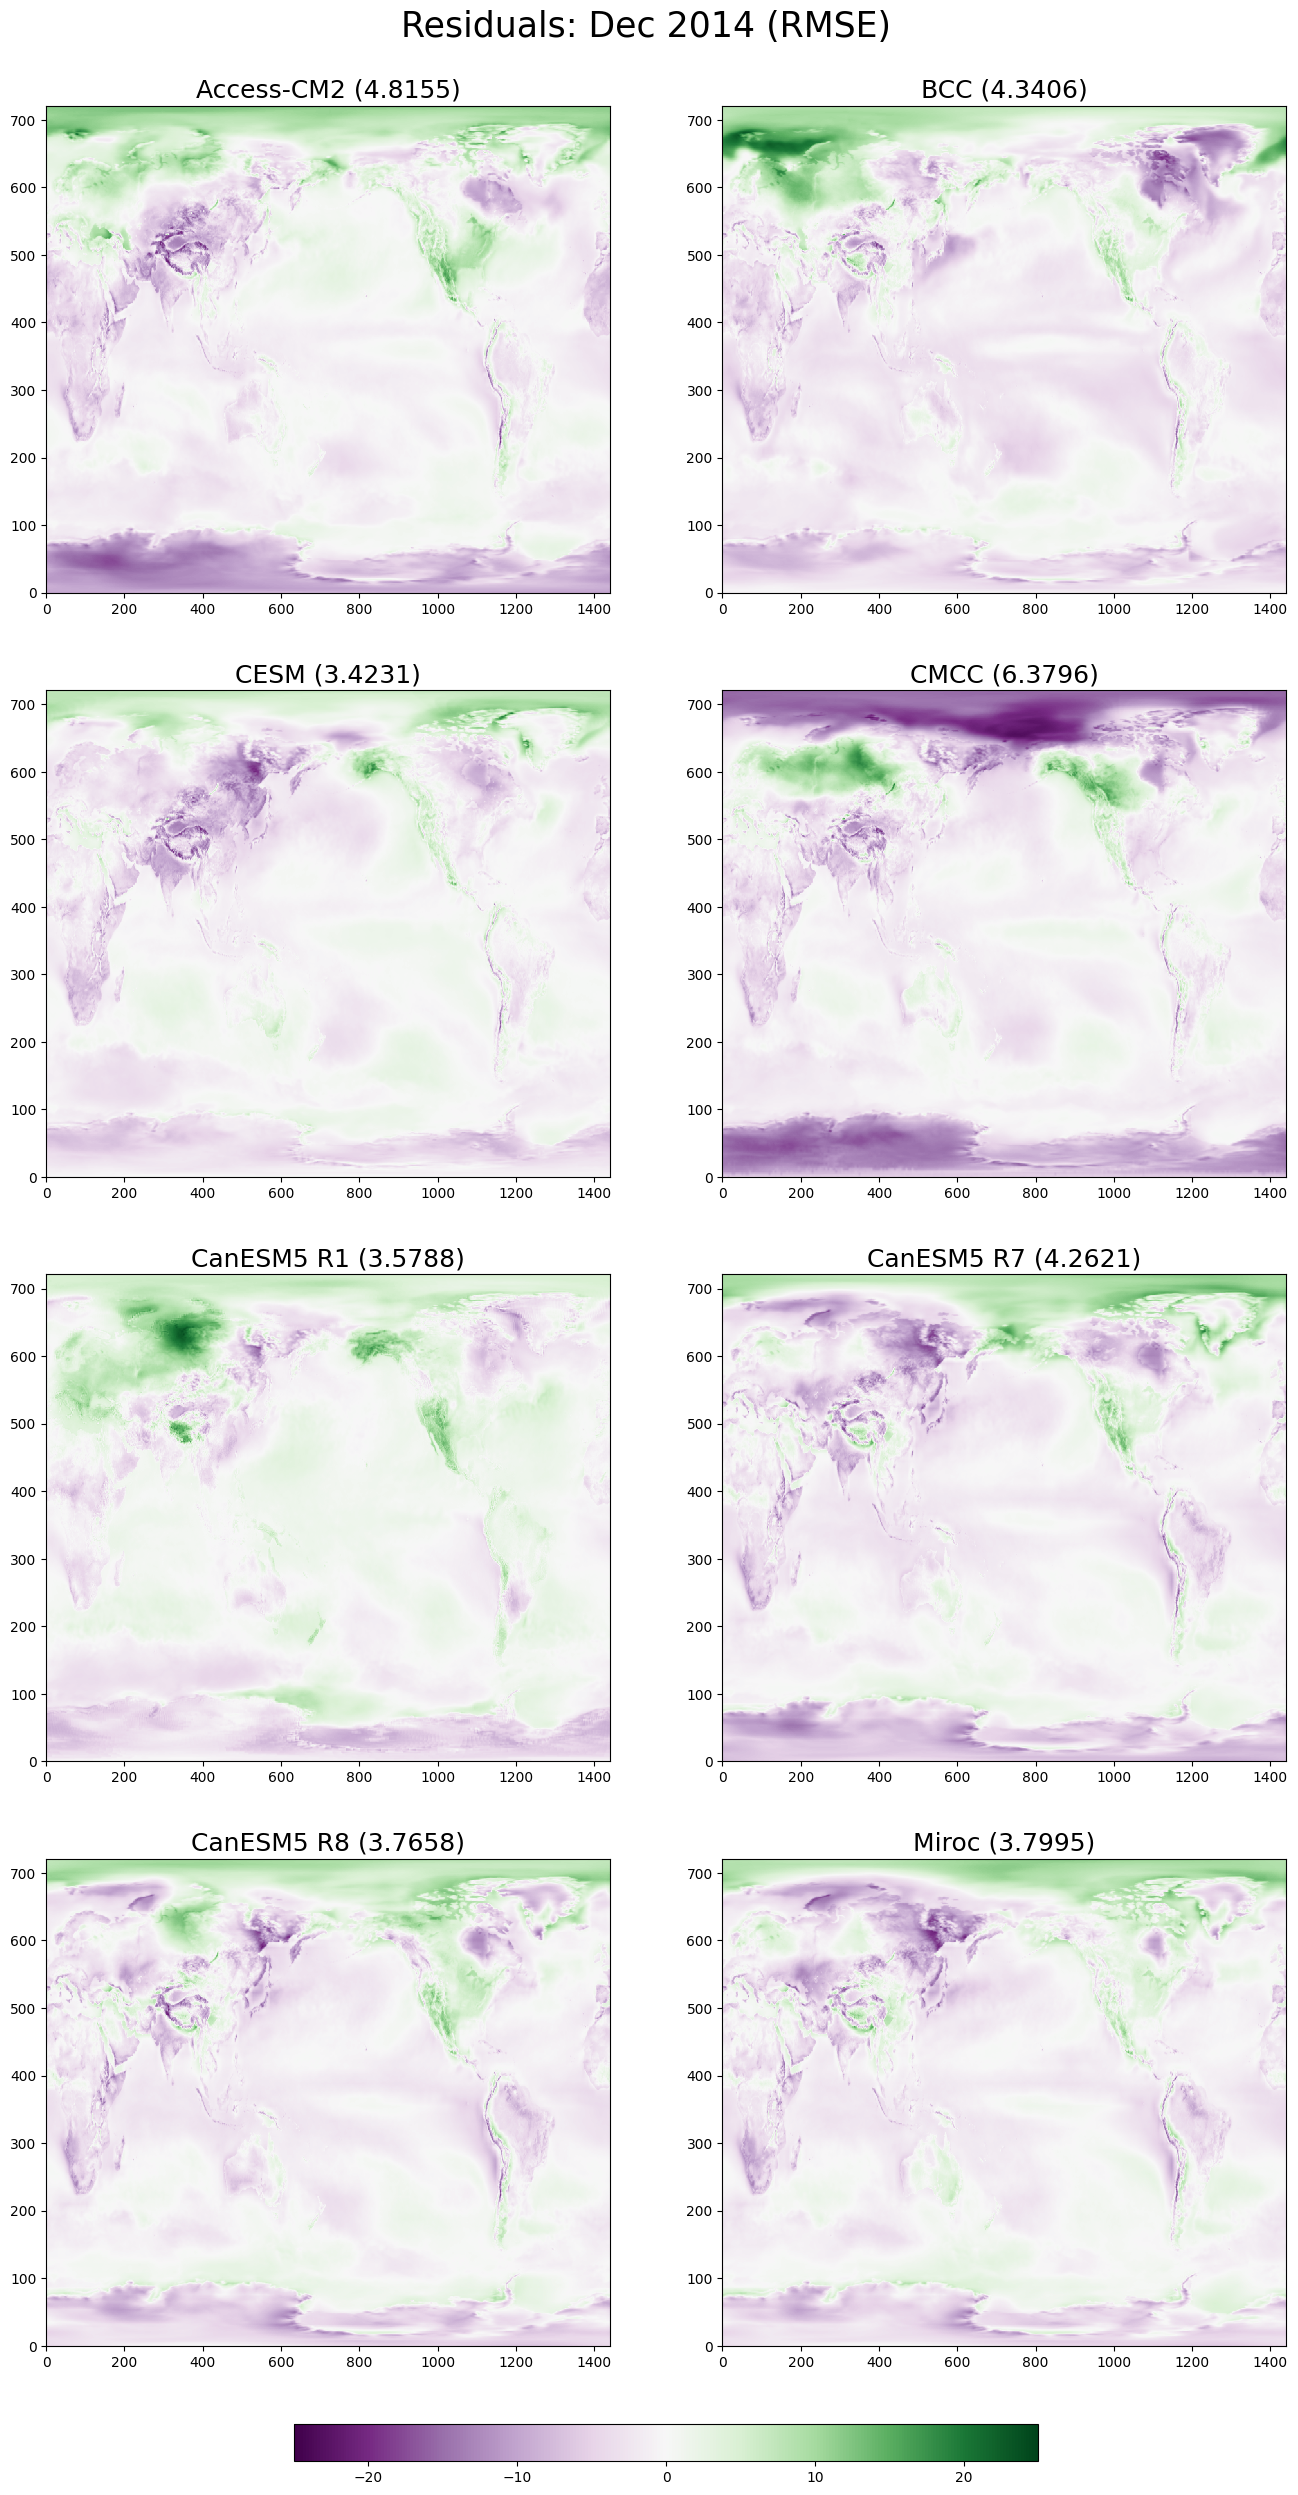

In [18]:
# Compare Residuals across models
fig, ax = plt.subplots(4,2,figsize = (16,32)) 
pcm0 = ax[0][0].pcolormesh(np.rot90(np.flip(resid_list[0].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm1 = ax[0][1].pcolormesh(np.rot90(np.flip(resid_list[1].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm2 = ax[1][0].pcolormesh(np.rot90(np.flip(resid_list[2].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm3 = ax[1][1].pcolormesh(np.rot90(np.flip(resid_list[3].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm4 = ax[2][0].pcolormesh(np.rot90(np.flip(resid_list[4].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm5 = ax[2][1].pcolormesh(np.rot90(np.flip(resid_list[5].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm6 = ax[3][0].pcolormesh(np.rot90(np.flip(resid_list[6].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm7 = ax[3][1].pcolormesh(np.rot90(np.flip(resid_list[7].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
ax[0][0].set_title("Access-CM2 (" + str(rmse_list[0]) + ")", size = 18)
ax[0][1].set_title("BCC (" + str(rmse_list[1]) + ")", size = 18)
ax[1][0].set_title("CESM (" + str(rmse_list[2]) + ")", size = 18)
ax[1][1].set_title("CMCC (" + str(rmse_list[3]) + ")", size = 18)
ax[2][0].set_title("CanESM5 R1 (" + str(rmse_list[4]) + ")", size = 18)
ax[2][1].set_title("CanESM5 R7 (" + str(rmse_list[5]) + ")", size = 18)
ax[3][0].set_title("CanESM5 R8 (" + str(rmse_list[6]) + ")", size = 18)
ax[3][1].set_title("Miroc (" + str(rmse_list[7]) + ")", size = 18)
fig.suptitle("Residuals: Dec 2014 (RMSE)", size = 25)
fig.colorbar(pcm7, ax = ax.ravel(), location = "bottom", shrink = 0.6)
fig.subplots_adjust(top = 0.95, bottom=0.25)
plt.show()


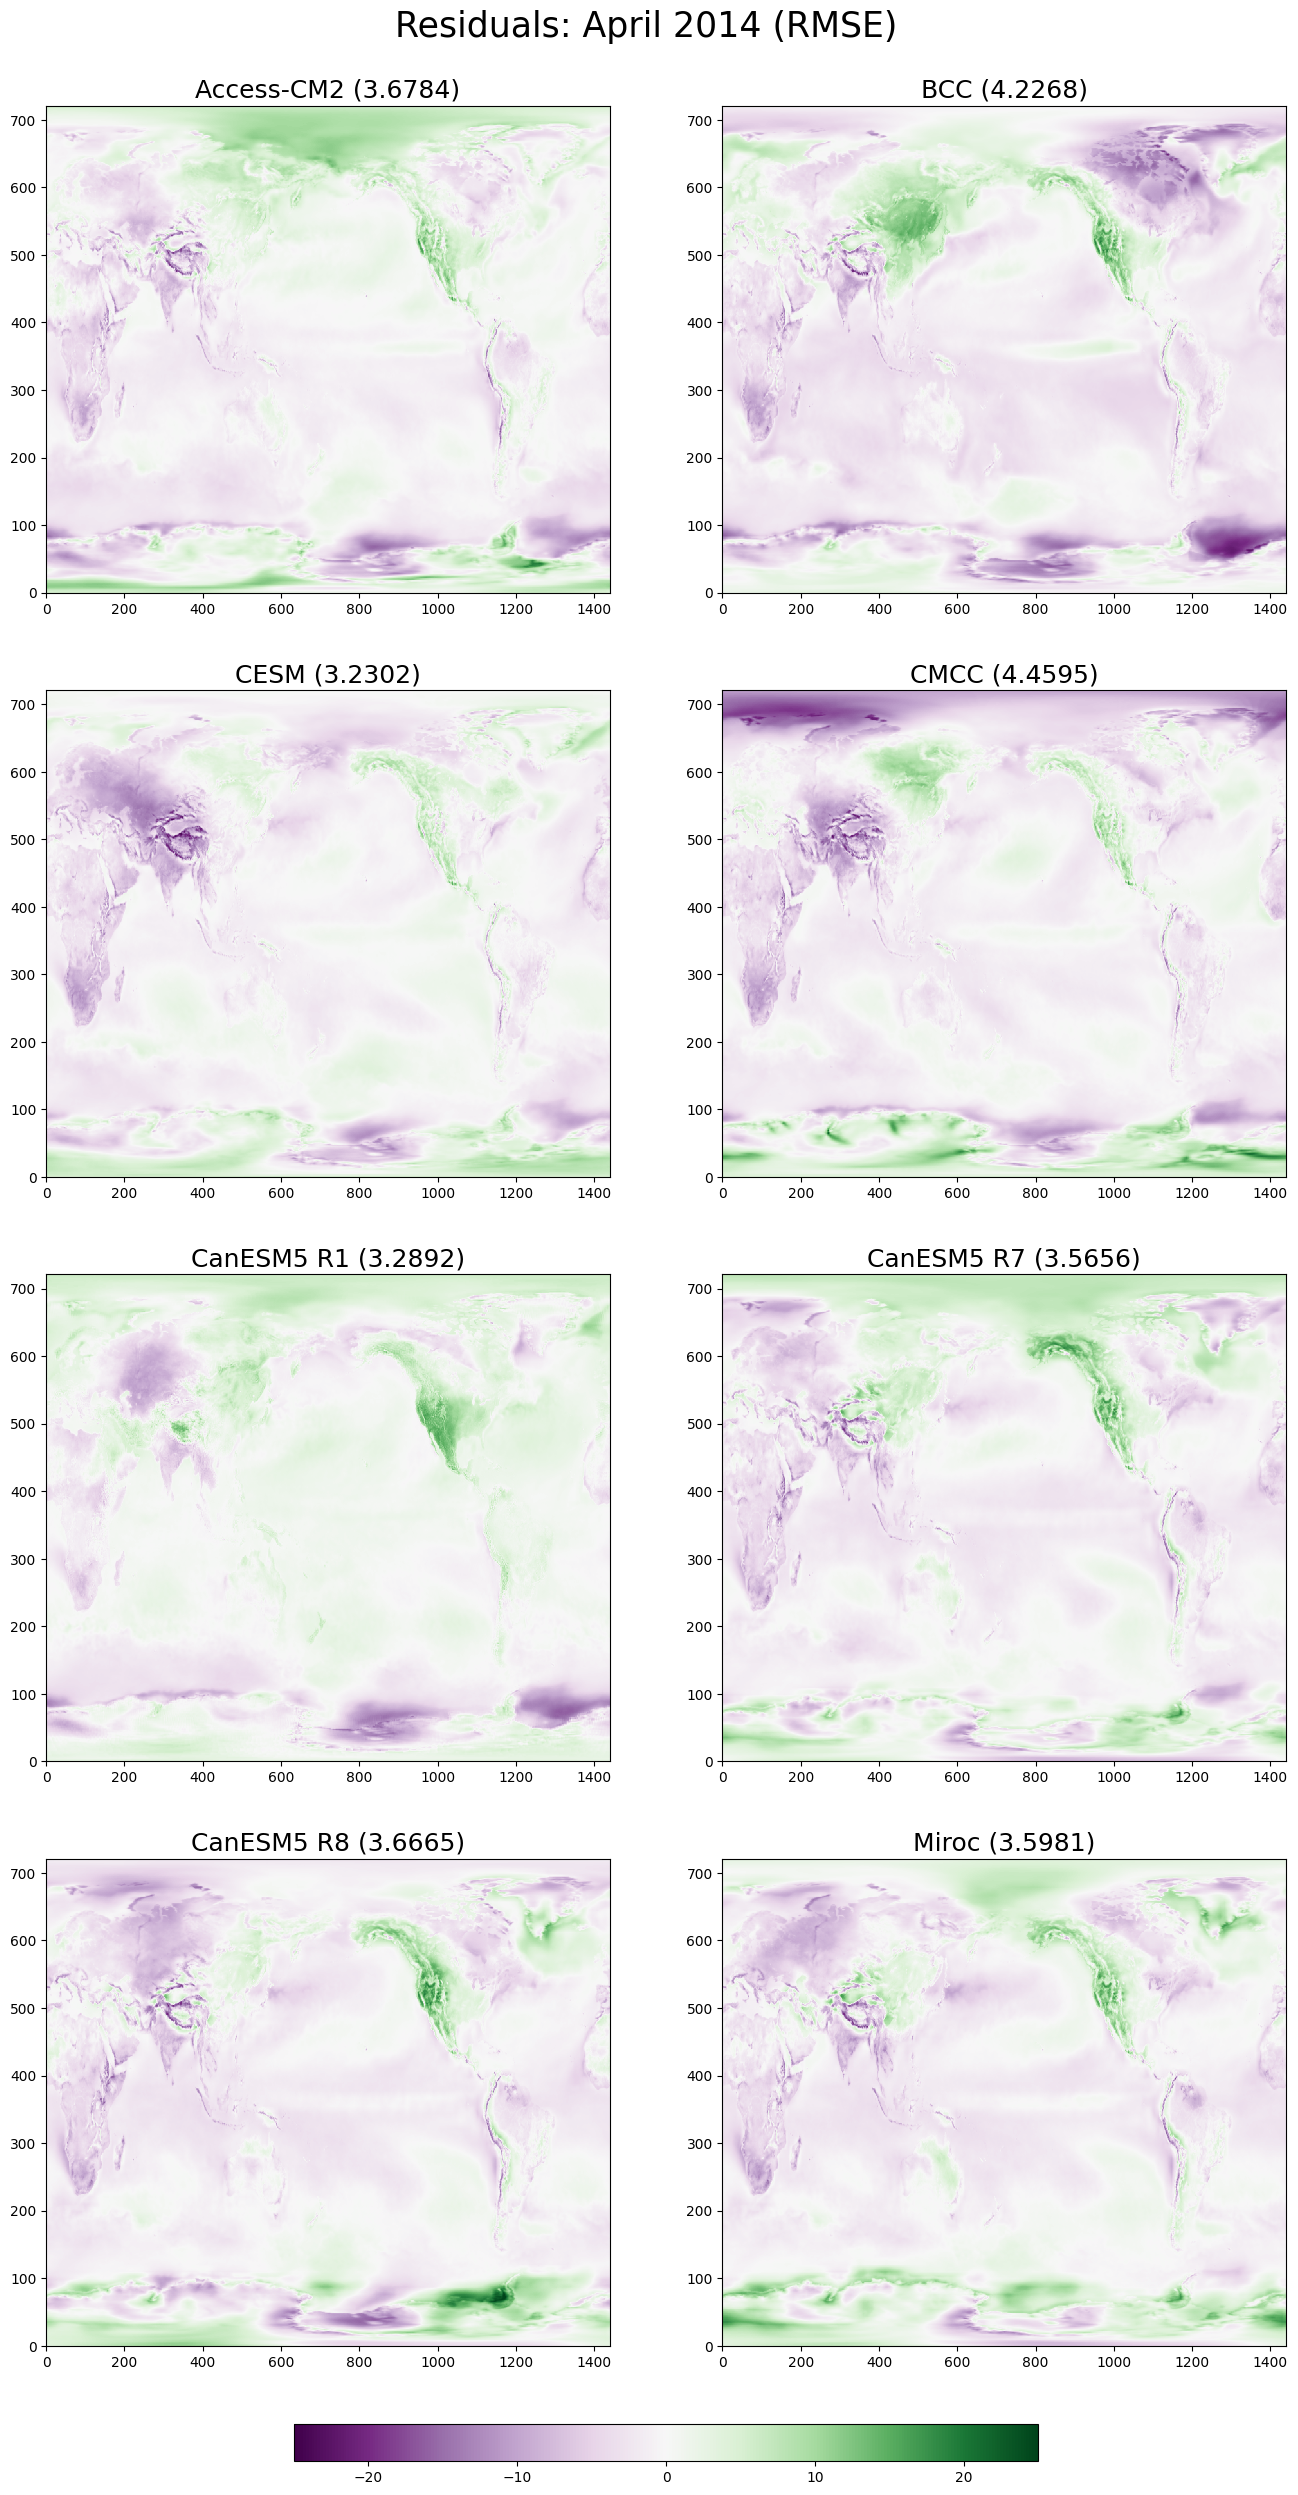

In [19]:
resid_list = []
rmse_list = []
for i,f in enumerate(cmpi6_interp_files):
    ncdata = nc.Dataset(cmpi6_interp_files[i], "r")
    xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 4, 1, 0, 0, 0, 0, 2, 15)))[0][0]
    resid = era5["t2m"][xx,0,:,:] - 273.15 - ncdata["tas"][3]
    resid_list.append(resid)
    rmse_list.append(np.array(np.round(np.sqrt(np.mean(resid**2)),4)))
    ncdata.close()


# Compare Residuals across models
fig, ax = plt.subplots(4,2,figsize = (16,32)) 
pcm0 = ax[0][0].pcolormesh(np.rot90(np.flip(resid_list[0].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm1 = ax[0][1].pcolormesh(np.rot90(np.flip(resid_list[1].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm2 = ax[1][0].pcolormesh(np.rot90(np.flip(resid_list[2].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm3 = ax[1][1].pcolormesh(np.rot90(np.flip(resid_list[3].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm4 = ax[2][0].pcolormesh(np.rot90(np.flip(resid_list[4].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm5 = ax[2][1].pcolormesh(np.rot90(np.flip(resid_list[5].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm6 = ax[3][0].pcolormesh(np.rot90(np.flip(resid_list[6].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
pcm7 = ax[3][1].pcolormesh(np.rot90(np.flip(resid_list[7].transpose()),k=3),cmap = "PRGn",vmin = -25,vmax = 25)
ax[0][0].set_title("Access-CM2 (" + str(rmse_list[0]) + ")", size = 18)
ax[0][1].set_title("BCC (" + str(rmse_list[1]) + ")", size = 18)
ax[1][0].set_title("CESM (" + str(rmse_list[2]) + ")", size = 18)
ax[1][1].set_title("CMCC (" + str(rmse_list[3]) + ")", size = 18)
ax[2][0].set_title("CanESM5 R1 (" + str(rmse_list[4]) + ")", size = 18)
ax[2][1].set_title("CanESM5 R7 (" + str(rmse_list[5]) + ")", size = 18)
ax[3][0].set_title("CanESM5 R8 (" + str(rmse_list[6]) + ")", size = 18)
ax[3][1].set_title("Miroc (" + str(rmse_list[7]) + ")", size = 18)
fig.suptitle("Residuals: April 2014 (RMSE)", size = 25)
fig.colorbar(pcm7, ax = ax.ravel(), location = "bottom", shrink = 0.6)
fig.subplots_adjust(top = 0.95, bottom=0.25)
plt.show()


### Comparing Interpolation Methods

Now consider applying the K-nearest nieghbors and inverse distance wedighting schemes to the simulator output. Results are shown below for both of these methods.

In [15]:
#----------------------------------------------------------
# CMIP6 NN and IDW interpolations -- Access-CM2
#----------------------------------------------------------
# Set the time period to be december 2014
tm = tas_data[c].shape[0] - 1

# Get cmpi6 mesh grid
cm6_llmesh = np.meshgrid(np.array(lon_data[0]),np.array(lat_data[0]))
cm6_lldf = pd.DataFrame()
cm6_lldf["lon"] = cm6_llmesh[0].ravel()
cm6_lldf["lat"] = cm6_llmesh[1].ravel()
cm6_lldf["t2m"] = tas_data[0][tm].ravel()
del cm6_llmesh

# Initialize the interpolators
nn1_interp = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=1, weights='uniform')
nn10_interp = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10, weights='uniform')
nn25_interp = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=25, weights='uniform')

idw5_interp = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=5, weights='distance')
idw25_interp = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=25, weights='distance')
idw100_interp = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=100, weights='distance')


# NN with different neighbor sizes
nn1_interp.fit(cm6_lldf[["lon","lat"]],cm6_lldf["t2m"])
nn1_pred = nn1_interp.predict(era5_lldf).reshape(721,1440)

nn10_interp.fit(cm6_lldf[["lon","lat"]],cm6_lldf["t2m"])
nn10_pred = nn10_interp.predict(era5_lldf).reshape(721,1440)

nn25_interp.fit(cm6_lldf[["lon","lat"]],cm6_lldf["t2m"])
nn25_pred = nn25_interp.predict(era5_lldf).reshape(721,1440)


# IDW with different neighbor sizes
idw5_interp.fit(cm6_lldf[["lon","lat"]],cm6_lldf["t2m"])
idw5_pred = idw5_interp.predict(era5_lldf).reshape(721,1440)

idw25_interp.fit(cm6_lldf[["lon","lat"]],cm6_lldf["t2m"])
idw25_pred = idw25_interp.predict(era5_lldf).reshape(721,1440)

idw100_interp.fit(cm6_lldf[["lon","lat"]],cm6_lldf["t2m"])
idw100_pred = idw100_interp.predict(era5_lldf).reshape(721,1440)


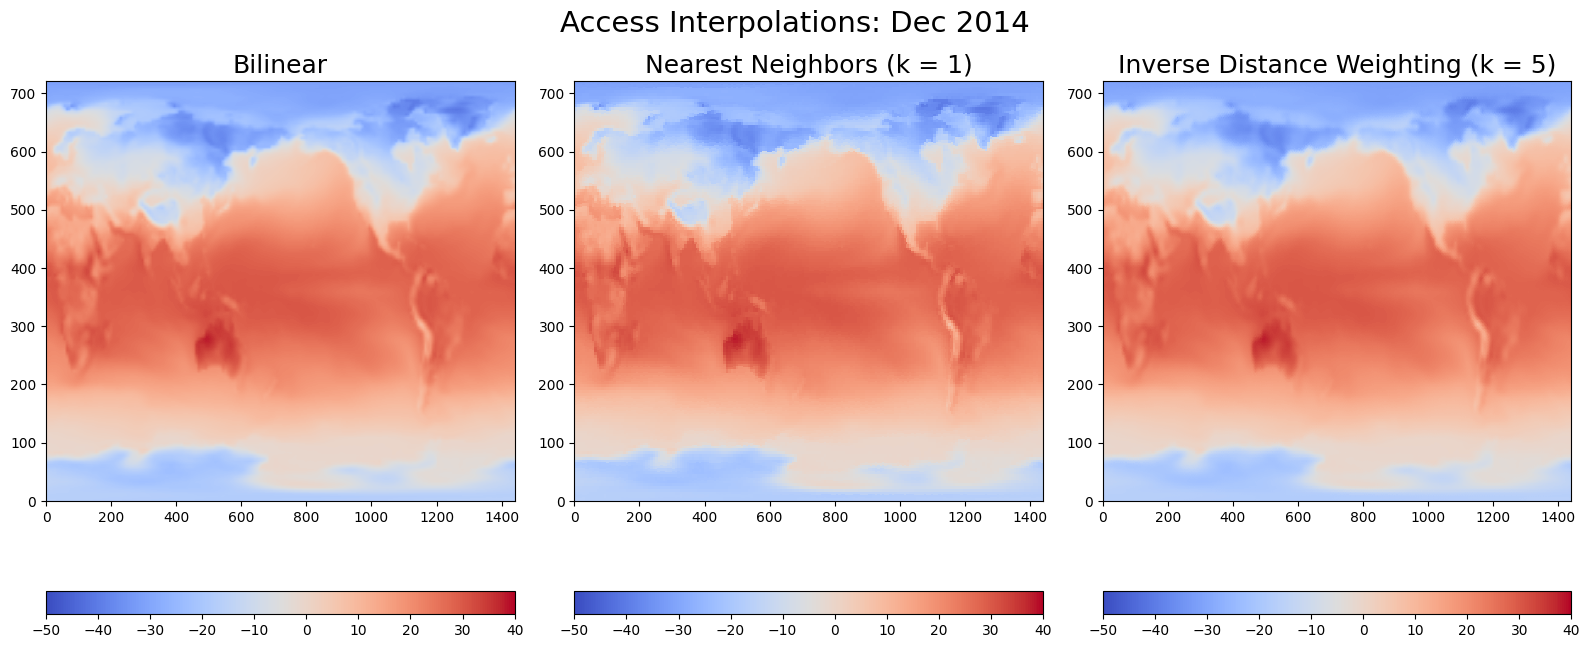

In [16]:
# Plot data
ncdata = nc.Dataset(cmpi6_interp_files[0], "r")

xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]

resid1 = era5["t2m"][xx,0,:,:] - 273.15 - ncdata["tas"][11]
resid_nn1 = era5["t2m"][xx,0,:,:] - 273.15 - nn1_pred
resid_idw5 = era5["t2m"][xx,0,:,:] - 273.15 - idw5_pred


fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(ncdata['tas'][11].transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(nn1_pred.transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(idw5_pred.transpose()),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("Bilinear", size = 18)
ax[1].set_title("Nearest Neighbors (k = 1)", size = 18)
ax[2].set_title("Inverse Distance Weighting (k = 5)", size = 18)
fig.suptitle("Access Interpolations: Dec 2014", size = 21)
fig.tight_layout()
plt.show()

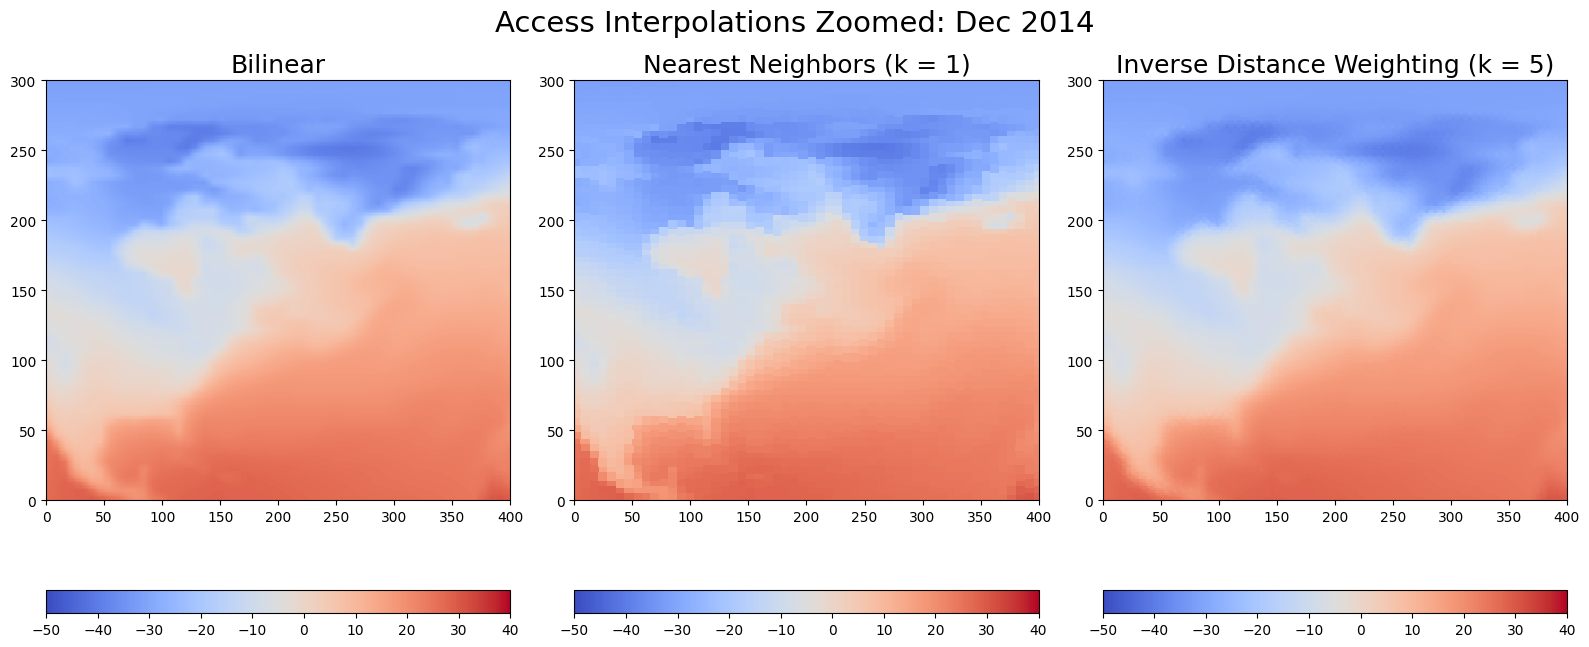

In [17]:
fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(ncdata['tas'][11].transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(nn1_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(idw5_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("Bilinear", size = 18)
ax[1].set_title("Nearest Neighbors (k = 1)", size = 18)
ax[2].set_title("Inverse Distance Weighting (k = 5)", size = 18)
fig.suptitle("Access Interpolations Zoomed: Dec 2014", size = 21)
fig.tight_layout()
plt.show()

### Nearest Neighbors and Inverse Distance Weighting

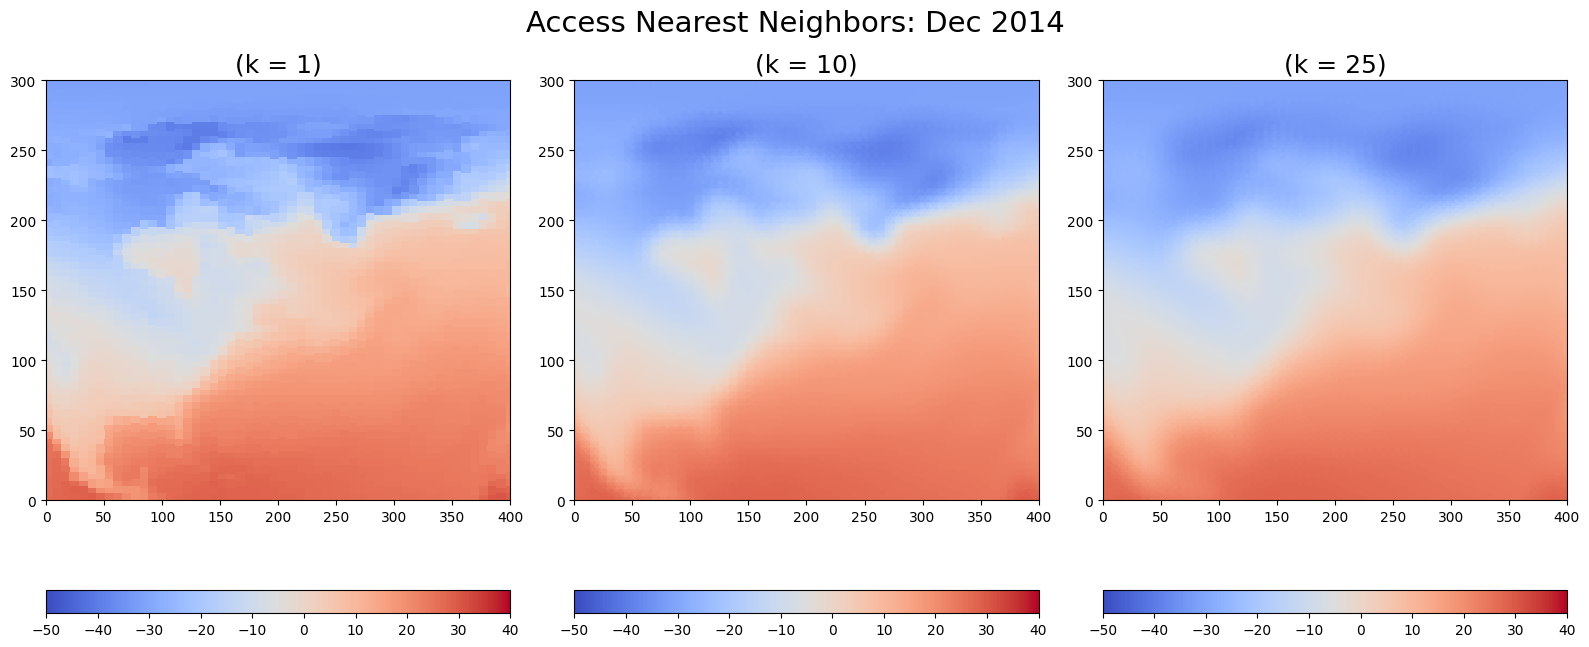

In [19]:
fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(nn1_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(nn10_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(nn25_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("(k = 1)", size = 18)
ax[1].set_title("(k = 10)", size = 18)
ax[2].set_title("(k = 25)", size = 18)
fig.suptitle("Access Nearest Neighbors: Dec 2014", size = 21)
fig.tight_layout()
plt.show()

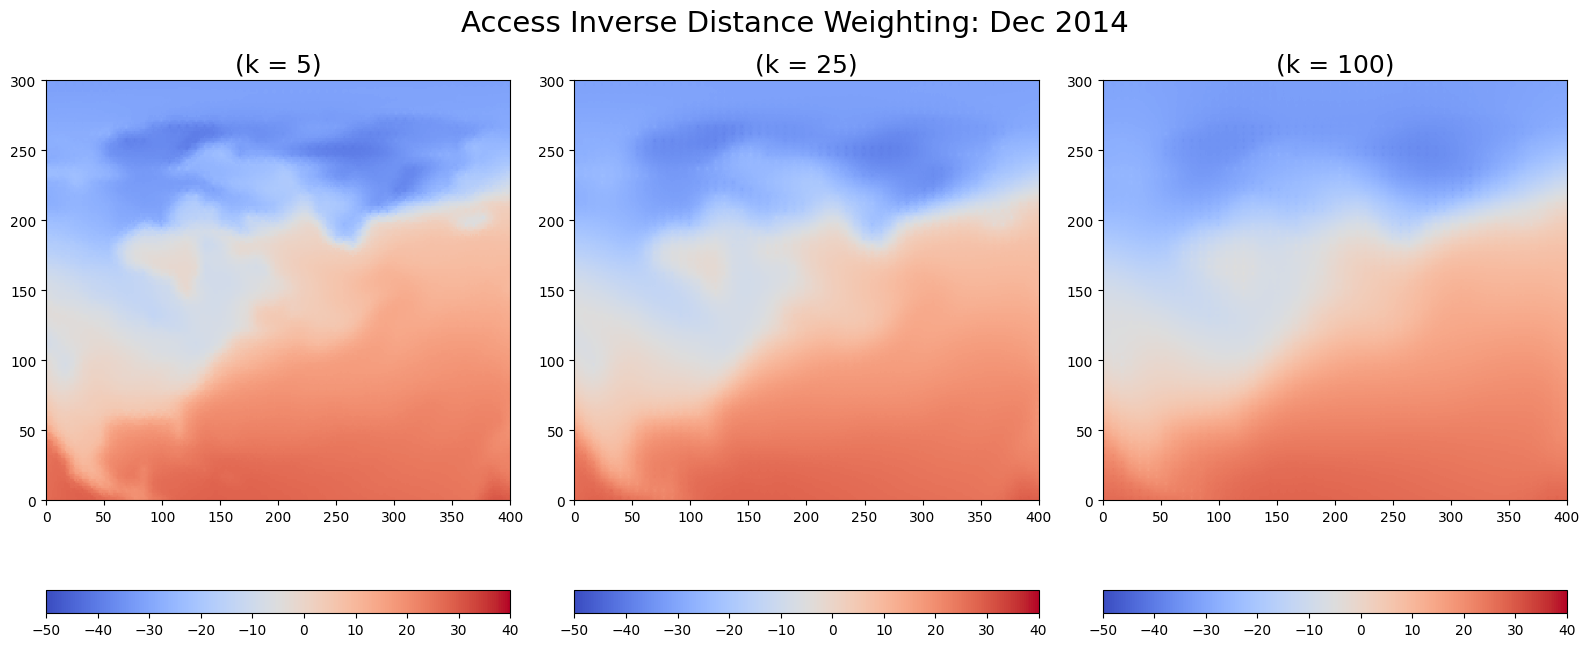

In [23]:
fig, ax = plt.subplots(1,3,figsize = (16,7)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(idw5_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(idw25_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
pcm2 = ax[2].pcolormesh(np.rot90(np.flip(idw100_pred.transpose()[1000:1400,0:300]),k=3),cmap = "coolwarm",vmin = -50,vmax = 40)
fig.colorbar(pcm0, ax = ax[0], location = "bottom")
fig.colorbar(pcm1, ax = ax[1], location = "bottom")
fig.colorbar(pcm2, ax = ax[2], location = "bottom")
ax[0].set_title("(k = 5)", size = 18)
ax[1].set_title("(k = 25)", size = 18)
ax[2].set_title("(k = 100)", size = 18)
fig.suptitle("Access Inverse Distance Weighting: Dec 2014", size = 21)
fig.tight_layout()
plt.show()

## Ranking Simulators

Finally, we can view where each simulator is the best performing/most accurate model (red), relative to the re-analysis data. Results are shown for two different time periods. It is evident that each simulator performs well in some region of the domain. 

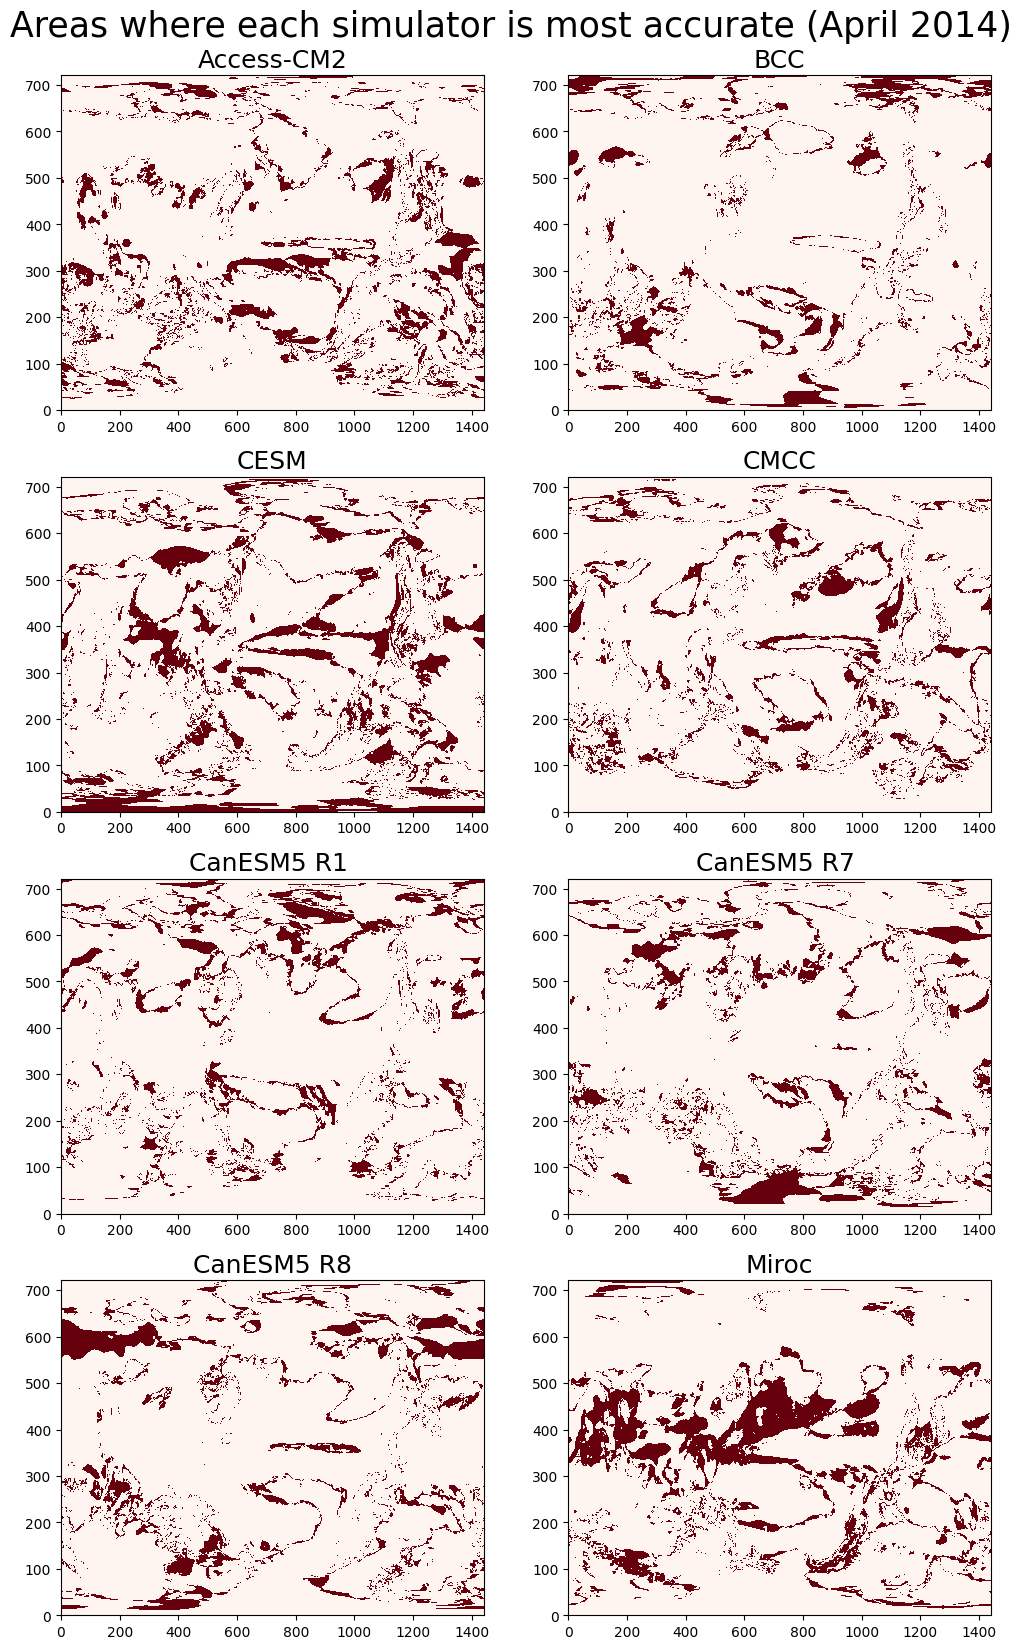

In [17]:
resid_list = []
mad_list = []
for i,f in enumerate(cmpi6_interp_files):
    ncdata = nc.Dataset(cmpi6_interp_files[i], "r")
    xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 4, 1, 0, 0, 0, 0, 2, 15)))[0][0]
    resid = era5["t2m"][xx,0,:,:] - 273.15 - ncdata["tas"][3]
    resid_list.append(resid)
    mad_list.append(np.array(np.round(np.abs(resid),4)))
    ncdata.close()

mad_array = np.array(mad_list)
mad_ranks = mad_array.argsort(axis = 0).argsort(axis = 0)
mad_best = mad_ranks.argmin(axis = 0)

fig, ax = plt.subplots(4,2,figsize = (12,22)) 
#ax.scatter(era5_lldf["lon"],era5_lldf["lat"],c = np.where(mad_ranks[1]==0,1,0))
ax[0][0].pcolormesh(np.where(mad_ranks[0]==0,1,0), cmap="Reds")
ax[0][1].pcolormesh(np.where(mad_ranks[1]==0,1,0), cmap="Reds")
ax[1][0].pcolormesh(np.where(mad_ranks[2]==0,1,0), cmap="Reds")
ax[1][1].pcolormesh(np.where(mad_ranks[3]==0,1,0), cmap="Reds")
ax[2][0].pcolormesh(np.where(mad_ranks[4]==0,1,0), cmap="Reds")
ax[2][1].pcolormesh(np.where(mad_ranks[5]==0,1,0), cmap="Reds")
ax[3][0].pcolormesh(np.where(mad_ranks[6]==0,1,0), cmap="Reds")
ax[3][1].pcolormesh(np.where(mad_ranks[7]==0,1,0), cmap="Reds")
ax[0][0].set_title("Access-CM2", size = 18)
ax[0][1].set_title("BCC", size = 18)
ax[1][0].set_title("CESM", size = 18)
ax[1][1].set_title("CMCC", size = 18)
ax[2][0].set_title("CanESM5 R1 ", size = 18)
ax[2][1].set_title("CanESM5 R7 ", size = 18)
ax[3][0].set_title("CanESM5 R8", size = 18)
ax[3][1].set_title("Miroc", size = 18)
fig.suptitle("Areas where each simulator is most accurate (April 2014)", size = 25)
fig.subplots_adjust(top = 0.95, bottom=0.25)
plt.show()



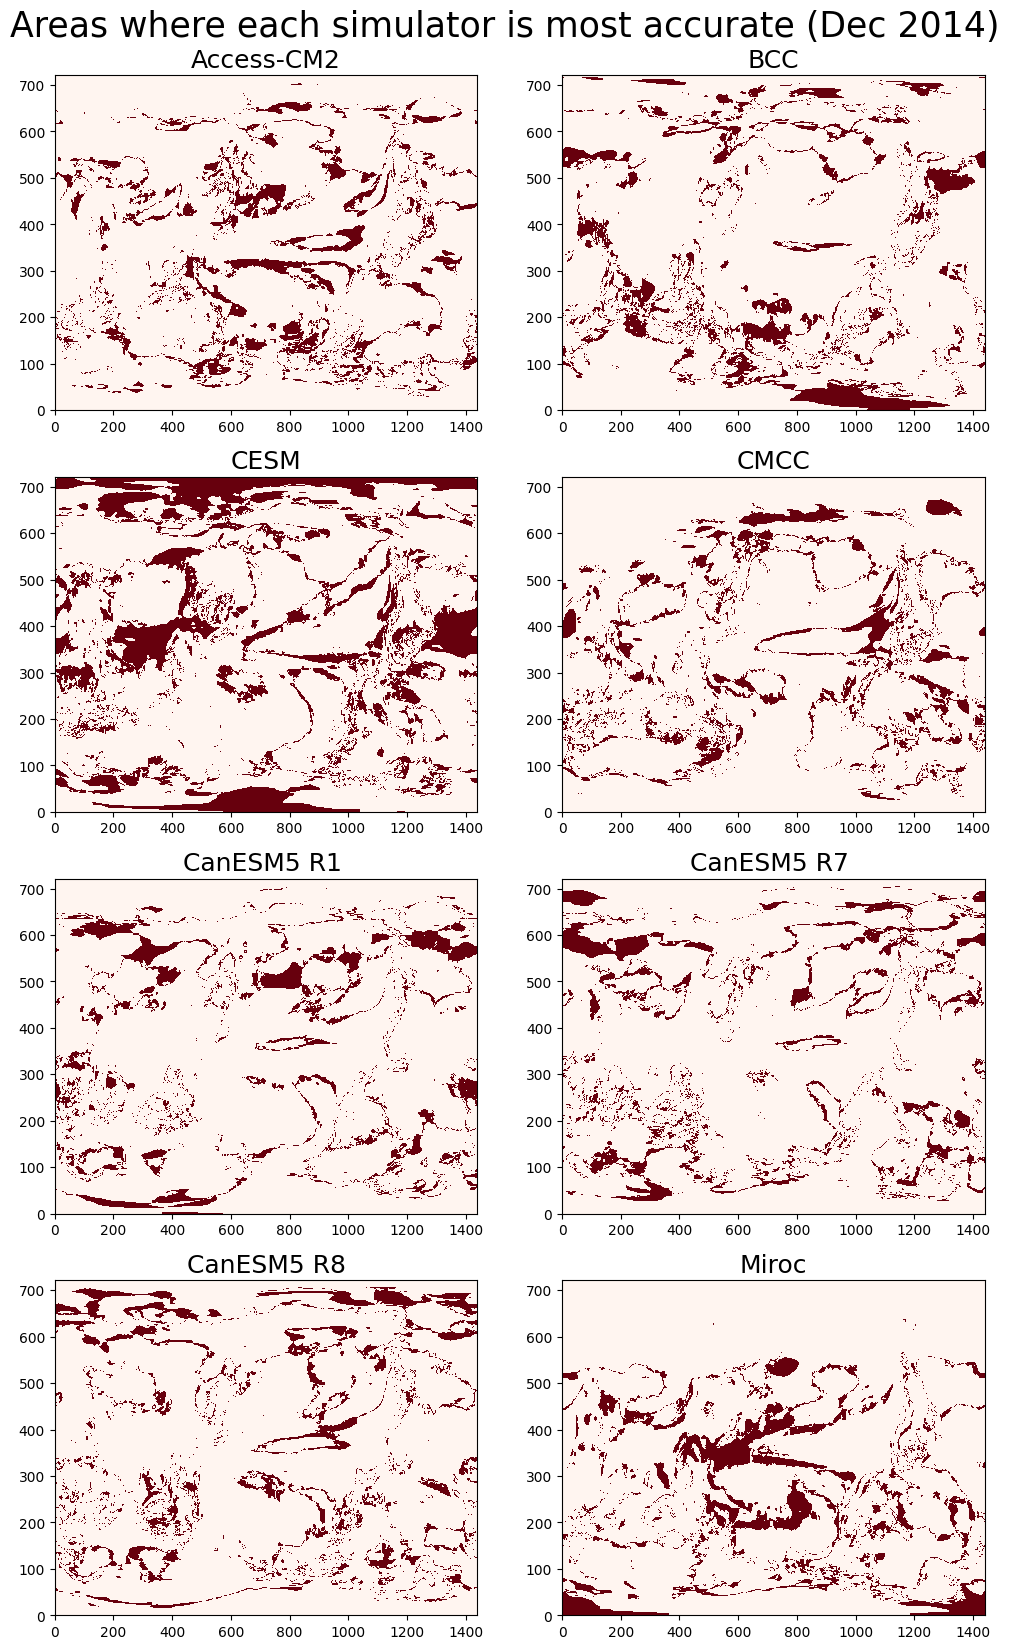

In [16]:
resid_list = []
mad_list = []
for i,f in enumerate(cmpi6_interp_files):
    ncdata = nc.Dataset(cmpi6_interp_files[i], "r")
    xx = np.where(era5["t2m"][:,0,:,:].time.isin(cftime.DatetimeGregorian(2014, 12, 1, 0, 0, 0, 0, 2, 15)))[0][0]
    resid = era5["t2m"][xx,0,:,:] - 273.15 - ncdata["tas"][11]
    resid_list.append(resid)
    mad_list.append(np.array(np.round(np.abs(resid),4)))
    ncdata.close()

mad_array = np.array(mad_list)
mad_ranks = mad_array.argsort(axis = 0).argsort(axis = 0)
mad_best = mad_ranks.argmin(axis = 0)

fig, ax = plt.subplots(4,2,figsize = (12,22)) 
#ax.scatter(era5_lldf["lon"],era5_lldf["lat"],c = np.where(mad_ranks[1]==0,1,0))
ax[0][0].pcolormesh(np.where(mad_ranks[0]==0,1,0), cmap="Reds")
ax[0][1].pcolormesh(np.where(mad_ranks[1]==0,1,0), cmap="Reds")
ax[1][0].pcolormesh(np.where(mad_ranks[2]==0,1,0), cmap="Reds")
ax[1][1].pcolormesh(np.where(mad_ranks[3]==0,1,0), cmap="Reds")
ax[2][0].pcolormesh(np.where(mad_ranks[4]==0,1,0), cmap="Reds")
ax[2][1].pcolormesh(np.where(mad_ranks[5]==0,1,0), cmap="Reds")
ax[3][0].pcolormesh(np.where(mad_ranks[6]==0,1,0), cmap="Reds")
ax[3][1].pcolormesh(np.where(mad_ranks[7]==0,1,0), cmap="Reds")
ax[0][0].set_title("Access-CM2", size = 18)
ax[0][1].set_title("BCC", size = 18)
ax[1][0].set_title("CESM", size = 18)
ax[1][1].set_title("CMCC", size = 18)
ax[2][0].set_title("CanESM5 R1 ", size = 18)
ax[2][1].set_title("CanESM5 R7 ", size = 18)
ax[3][0].set_title("CanESM5 R8", size = 18)
ax[3][1].set_title("Miroc", size = 18)
fig.suptitle("Areas where each simulator is most accurate (Dec 2014)", size = 25)
fig.subplots_adjust(top = 0.95, bottom=0.25)
plt.show()



## Extra Plots

/tmp/ipykernel_5729/3500274259.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xlabels)
/tmp/ipykernel_5729/3500274259.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xlabels)
/tmp/ipykernel_5729/3500274259.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
/tmp/ipykernel_5729/3500274259.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


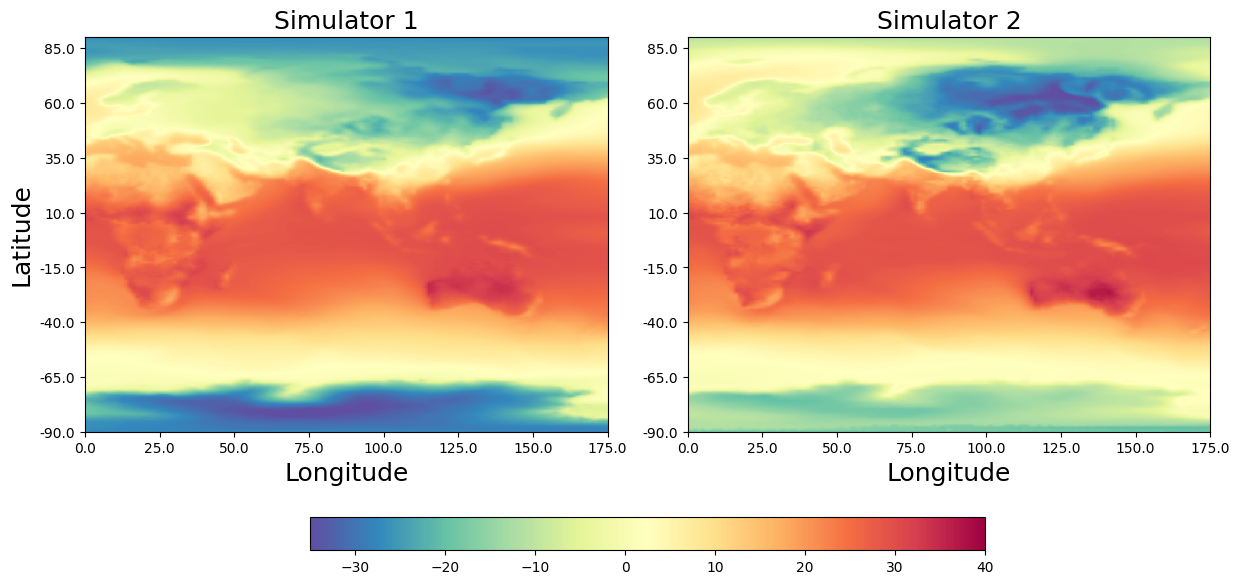

In [124]:
# Plot data
ncdata1 = nc.Dataset(cmpi6_interp_files[2], "r")
ncdata2 = nc.Dataset(cmpi6_interp_files[1], "r")
ncdata4 = nc.Dataset(cmpi6_interp_files[3], "r")

ndim = ncdata1['tas'][0].transpose().shape

fig, ax = plt.subplots(1,2,figsize = (12.5,6.75)) 
pcm0 = ax[0].pcolormesh(np.rot90(np.flip(ncdata1['tas'][0].transpose()[0:700,0:ndim[1]]),k=3),cmap = "Spectral_r",vmin = -35,vmax = 40)
pcm1 = ax[1].pcolormesh(np.rot90(np.flip(ncdata4['tas'][0].transpose()[0:700,0:ndim[1]]),k=3),cmap = "Spectral_r",vmin = -35,vmax = 40)
ax[0].set_title("Simulator 1", size = 18)
ax[1].set_title("Simulator 2", size = 18)

#xlabels = [int(item.get_text()) for item in ax[0].get_xticklabels()]
#xlabels = [int(float(x)*360)/ndim[0] for x in xlabels]

#ylabels = [item.get_text() for item in ax[0].get_yticklabels()]
#ylabels = [int(int(x)*180/ndim[1]-90) for x in ylabels]
xlabels = era5_lon[np.arange(0,800,100)]
ylabels = np.flip(era5_lat)[np.arange(0,800,100)]

ax[0].set_xticklabels(xlabels)
ax[1].set_xticklabels(xlabels)
ax[0].set_yticklabels(ylabels)
ax[1].set_yticklabels(ylabels)

ax[0].set_xlabel("Longitude", size = 18)
ax[1].set_xlabel("Longitude", size = 18)
ax[0].set_ylabel("Latitude", size = 18)

fig.tight_layout()
fig.colorbar(pcm1, ax = ax.ravel(), location = "bottom", shrink = 0.6)
#fig.subplots_adjust(top = 0.95, bottom=0.25)
plt.show()

ncdata1.close()
ncdata2.close()
ncdata4.close()


In [83]:
xlabels = [item.get_text() for item in ax[0].get_xticklabels()]
xlabels = [int(int(x)*360/ndim[0]) for x in xlabels]
xlabels


xlabels = [int(item.get_text()) for item in ax[0].get_xticklabels()]
xlabels = [int(float(x)*360)/ndim[0] for x in xlabels]
xlabels

[0.0, 25.0, 50.0, 75.0, 100.0, 125.0, 150.0, 175.0]

In [91]:
ylabels = [item.get_text() for item in ax[0].get_yticklabels()]
ylabels = [int(int(x)*180/ndim[1]-90) for x in ylabels]
ylabels


[-90, -65, -40, -15, 9, 34, 59, 84, 109]

array([-90., -65., -40., -15.,  10.,  35.,  60.,  85.], dtype=float32)

array([  0, 100, 200, 300, 400, 500, 600, 700])